<a href="https://colab.research.google.com/github/Cleanliness/BazaarPredictor/blob/main/BzrModelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# ML stuff
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler

# data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# constants for hourly model
WINDOW_SIZE = 29
PREDICT_SIZE = 3

Sign in with bazaar ticker email to get training data from bazaar ticker google drive

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the hourly data csv


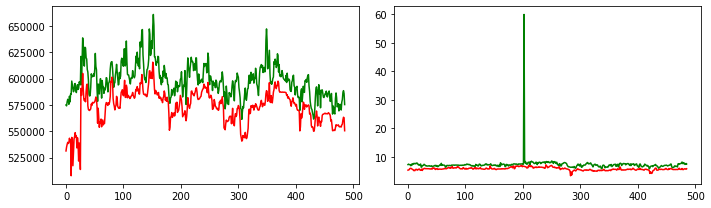

In [63]:
buy_df = pd.read_csv('/content/drive/My Drive/hourly_dat/set1_buy_hour.csv')
sell_df = pd.read_csv('/content/drive/My Drive/hourly_dat/set1_sell_hour.csv')

# getting + normalizing timestamps, column names
timestamps = buy_df["Unnamed: 0"]
cols = list(buy_df)[1:-1]
hrs = np.divide(np.floor_divide(timestamps, 10000), 23)

# converting df to numpy array, transpose so that rows are items, columns are timestamps
df_train_bp = buy_df[cols].astype(float).to_numpy()
df_train_bp = df_train_bp.transpose()

df_train_sp = sell_df[cols].astype(float).to_numpy()
df_train_sp = df_train_sp.transpose()

# plot raw buy and sell data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(list(buy_df["SUMMONING_EYE"]), color='g')
axes[1].plot(list(buy_df["IRON_INGOT"]), color='g')

axes[0].plot(list(sell_df["SUMMONING_EYE"]), color='r')
axes[1].plot(list(sell_df["IRON_INGOT"]), color='r')

fig.tight_layout()

Get rid of huge spikes in the dataset by smoothing them out (see iron ingot graph) - We want the model to learn short term trends in bazaar prices. Smooth out outliers (4 standard deviations from mean) by replacing them with local mean (window size = 15). Repeat this 5 times, since smaller spikes may exist, or large spikes might need multiple smoothings.

In [64]:
def remove_outliers(bzr_dat, run_lim=5):
    runs = 0
    old_adjusted = bzr_dat
    adjusted_prices = []

    while runs < run_lim:
        for item_row in old_adjusted:
            item_mean, item_sdev = np.mean(item_row), np.std(item_row)
            l_bound, u_bound = item_mean - 4 * item_sdev, item_mean + 4 * item_sdev

            adjusted_row = []
            for price_ind in range(0, len(item_row)):
                itm_price = item_row[price_ind]

                # outlier detected, replace it with an intermediate value (less harmful to training model?)
                if itm_price < l_bound or itm_price > u_bound:
                    window_sum, i_l, i_r, count = 0, 1, 1, 0

                    # get average of neighboring values
                    while i_l + i_r - 2 < 15:
                        if price_ind - 1 in range(0, len(item_row)):
                            window_sum += item_row[price_ind - 1]
                            i_l += 1
                            count += 1

                        if price_ind + 1 in range(0, len(item_row)):
                            window_sum += item_row[price_ind + 1]
                            i_r += 1
                            count += 1

                    if count == 0:
                        # shouldn't happen, but catch this case to avoid div by 0
                        res = 0
                        print("no neighboring values, set adjusted point to 0")
                    else:
                        res = window_sum / count

                    # adding adjusted point to this row, i.e item price sequence
                    adjusted_row.append(res)

                else:
                    adjusted_row.append(itm_price)

            adjusted_prices.append(adjusted_row)

        old_adjusted = adjusted_prices
        adjusted_prices = []
        runs += 1
    return old_adjusted


Remove outliers for buy and sell prices. Notice that the spike in the iron ingot graph is now removed, and the summoning eye graph remains unchanged.

finished outlier removal from dataset


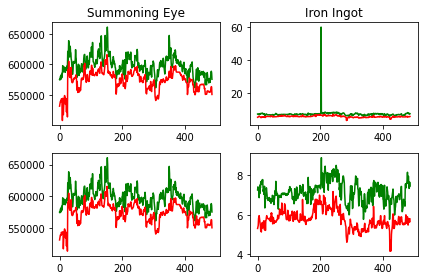

In [65]:
df_train_bp = remove_outliers(df_train_bp)
df_train_sp = remove_outliers(df_train_sp)
print("finished outlier removal from dataset")

# plotting adjusted buy and sell dataframes
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(list(buy_df["SUMMONING_EYE"]), color='g')
ax1.plot(list(sell_df["SUMMONING_EYE"]), color='r')
ax2.plot(list(buy_df["IRON_INGOT"]), color='g')
ax2.plot(list(sell_df["IRON_INGOT"]), color='r')

ax3.plot(list(df_train_bp[cols.index("SUMMONING_EYE")]), color='g')
ax4.plot(list(df_train_bp[cols.index("IRON_INGOT")]), color='g')
ax3.plot(list(df_train_sp[cols.index("SUMMONING_EYE")]), color='r')
ax4.plot(list(df_train_sp[cols.index("IRON_INGOT")]), color='r')

ax2.set_title("Iron Ingot")
ax1.set_title("Summoning Eye")
f.tight_layout()

Use a sliding window over the dataframes to generate our dataset. Dataset is formatted as follows, where x is the input tensor, and y is the label. (make better img later)

m = number of input timesteps

n = number of samples

number of variables = 3 (buy, sell, time of day)
*** disregard the dimensions***

<img src='https://drive.google.com/uc?id=1E1DPlZt4fnu9XWCdTmzld7MFQaNOEqZC' width=500>

In [100]:
def create_dataset(prices, timestamps, window_size, pred_size):
    """Generates and returns inputs and labels. Assume buy and sell have the same shape"""
    inputs, labels = [], []
    scaler = MinMaxScaler()

    for row_i in range(0, len(prices)):
        for frame_start in range(0, len(prices[row_i]) - (window_size + pred_size)):

            # getting entire window and normalizing it
            p_row = np.array([prices[row_i][frame_start: window_size + frame_start + pred_size]]).transpose()
            scaler.fit(p_row)
            p_row = scaler.transform(p_row).transpose()

            # getting input and label windows
            p_in = p_row[0][: window_size]
            time_in = timestamps[frame_start: window_size + frame_start]

            p_lbl = p_row[0][window_size:]

            # adding windows to inputs and labels list
            inputs.append([p_in, time_in])
            labels.append(p_lbl)
            
    return np.array(inputs), np.array(labels)

Generate our dataset from set 1 and 2. for input we have shape corresponding to: (# of samples, # of variables, length of timespan). Output is the buy and sell predictions but flattened onto a vector

In [101]:
# generating dataset from set 2
buy_df2 = pd.read_csv('/content/drive/My Drive/hourly_dat/set1_buy_hour.csv')
sell_df2 = pd.read_csv('/content/drive/My Drive/hourly_dat/set1_sell_hour.csv')

# getting + normalizing timestamps, column names
timestamps2 = buy_df2["Unnamed: 0"]
cols2 = list(buy_df2)[1:-1]
hrs2 = np.divide(np.floor_divide(timestamps2, 10000), 23)

# converting df to numpy array, transpose so that rows are items, columns are timestamps
df_train_bp2 = buy_df2[cols2].astype(float).to_numpy()
df_train_bp2 = df_train_bp2.transpose()

df_train_sp2 = sell_df2[cols2].astype(float).to_numpy()
df_train_sp2 = df_train_sp2.transpose()

# remove outliers
df_train_bp2 = remove_outliers(df_train_bp2)
df_train_sp2 = remove_outliers(df_train_sp2)
print("finished outlier removal from dataset")

# create dataset
train_x2, train_y2 = create_dataset(df_train_bp2, hrs2, WINDOW_SIZE, PREDICT_SIZE)
print("dataset created")
print(train_x2.shape)
print(train_y2.shape)

finished outlier removal from dataset
dataset created
(102604, 2, 29)
(102604, 3)


Concatenate the datasets from set 1 and 2, then shuffle. The plot below is an example of an input and label (i.e expected values)

(205208, 2, 29)
(205208, 3)


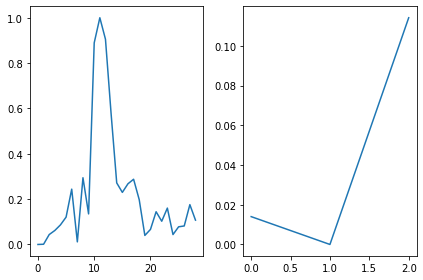

In [102]:
train_x1, train_y1 = create_dataset(df_train_bp, hrs, WINDOW_SIZE, PREDICT_SIZE)

# concatenate 2 datasets
train_x, train_y = np.concatenate((train_x1, train_x2)), np.concatenate((train_y1, train_y2))

np.random.shuffle(train_x)
np.random.shuffle(train_y)

f, (ax1, ax4) = plt.subplots(1, 2)
ax1.plot(list(train_x[0][0]))
ax4.plot(list(train_y2[0]))

print(train_x.shape)
print(train_y.shape)

f.tight_layout()

Define model architecture

In [103]:
bzr_model = Sequential()

bzr_model.add(LSTM(400, input_shape=(2, WINDOW_SIZE), return_sequences=True))
bzr_model.add(LSTM(200, activation='relu'))

bzr_model.add(Dense(200, activation='relu'))
bzr_model.add(Dense(150, activation='relu'))

bzr_model.add(Dense(PREDICT_SIZE))

bzr_opt = tf.keras.optimizers.Adadelta(
    learning_rate=0.0005, rho=0.95, epsilon=1e-07, name="Adadelta"
)

bzr_model.compile(optimizer=bzr_opt, loss='mse', metrics=['accuracy'])
bzr_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 2, 400)            688000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dense_12 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_13 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 453       
Total params: 1,239,603
Trainable params: 1,239,603
Non-trainable params: 0
_________________________________________________________________


train the model

In [104]:
history = bzr_model.fit(train_x2, train_y2, epochs=100, batch_size=100, validation_split=0.1, verbose=1)

Epoch 1/100
924/924 [==============================] - 56s 57ms/step - loss: 0.3045 - accuracy: 0.2311 - val_loss: 0.3113 - val_accuracy: 0.2096
Epoch 2/100
924/924 [==============================] - 52s 57ms/step - loss: 0.2899 - accuracy: 0.1988 - val_loss: 0.2914 - val_accuracy: 0.2085
Epoch 3/100
924/924 [==============================] - 52s 56ms/step - loss: 0.2710 - accuracy: 0.1979 - val_loss: 0.2676 - val_accuracy: 0.2087
Epoch 4/100
924/924 [==============================] - 52s 56ms/step - loss: 0.2459 - accuracy: 0.1971 - val_loss: 0.2409 - val_accuracy: 0.2086
Epoch 5/100
924/924 [==============================] - 53s 57ms/step - loss: 0.2212 - accuracy: 0.1984 - val_loss: 0.2126 - val_accuracy: 0.2084
Epoch 6/100
924/924 [==============================] - 53s 57ms/step - loss: 0.1950 - accuracy: 0.1991 - val_loss: 0.1840 - val_accuracy: 0.2084
Epoch 7/100
924/924 [==============================] - 52s 57ms/step - loss: 0.1681 - accuracy: 0.1959 - val_loss: 0.1579 - val_ac

Plotting stats after training


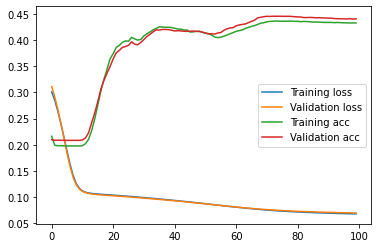

In [105]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.legend()

comparing predictions to actual

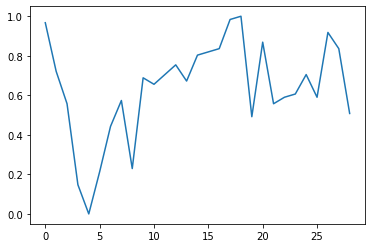

In [144]:
# row of training data
row = 2173
plt.plot(train_x[row][0])

[[0.67058235 0.65822834 0.6349788 ]]
[0.32362565 0.3164267  0.26865183]


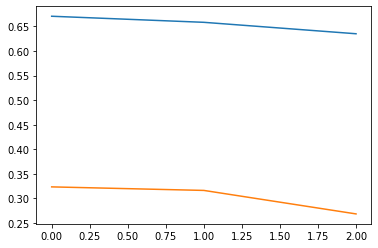

In [145]:
# prediction = blue, actual = orange
prediction = bzr_model.predict(train_x[row:row+1])
print(prediction)
print(train_y[row])
plt.plot(prediction[0])
plt.plot(train_y[row])

In [148]:
# save model if looks successful
from google.colab import files
bzr_model.save("data/bzr_3h_model2.keras")


In [151]:
# download the model
files.download( "data/bzr_3h_model2.keras" ) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>